# SECTIONS

1. Overall accuracy by model+embedding
2. Confusion Matrices
    - Precision/Recall plots
    - Confusion matrix plots
3. AI Interpretability, distilBERT/BERT

In [17]:
import os 
import pickle 
import model_funcs as mf
import numpy as np
import pandas as pd
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [18]:
train_x, test_x, train_y, test_y, label_map  = mf.get_train_test()

In [19]:
models = ['svm', 'xgb', 'bilstm', 'bert-based-uncased-', 'distilbert-base-uncased-', 'roberta-base-']
embeddings = list(mf.embedding_funcs.keys())

In [20]:
label_map
classes = list(label_map.keys())

# 1.  Overall Results

In [21]:
test_results = pd.read_csv('results/results.csv')
test_results[['model', 'embedding']] = test_results['model_name'].str.split('-', 1, expand=True)
test_results = test_results[['model_name', 'model', 'embedding', 'accuracy', 'f1']]
test_results[['accuracy', 'f1']] = test_results[['accuracy', 'f1']]*100.0
test_results

,model_name,model,embedding,accuracy,f1
0,svm-word2vec,svm,word2vec,82.10,82.27
1,svm-glove,svm,glove,79.40,79.56
2,svm-fasttext,svm,fasttext,80.40,80.78
3,svm-custom,svm,custom,80.40,80.72
4,xgb-word2vec,xgb,word2vec,78.98,79.26
5,xgb-glove,xgb,glove,74.29,73.85
6,xgb-fasttext,xgb,fasttext,78.69,78.83
7,xgb-custom,xgb,custom,79.55,79.68
8,roberta-base,roberta,base,84.09,83.94
9,distilbert-base-uncased,distilbert,base-uncased,83.10,83.31


In [22]:
test_results.groupby('model').mean().sort_values('accuracy', ascending = False)


,accuracy,f1
model,,
roberta,84.0900,83.9400
distilbert,83.1000,83.3100
bilstm,80.5775,80.5500
svm,80.5750,80.8325
bert,79.9700,79.7700
xgb,77.8775,77.9050


In [23]:
test_results.groupby('embedding').mean().sort_values('accuracy', ascending = False)


,accuracy,f1
embedding,,
base,84.090000,83.940000
base-uncased,81.535000,81.540000
custom,80.543333,80.633333
word2vec,80.446667,80.623333
fasttext,79.593333,79.856667
glove,78.123333,77.936667


# 2. Confusion Matrices

## Precision/Recall Plots

In [96]:
def plot_results(model, bert = 0):
    metrics = ['precision', 'recall', 'f1-score']
    colors = ['cyan', 'orange', 'green', 'brown']
    width_mapping = [-2, -1, 0, 1]
    x = np.arange(len(label_map.keys()))
    width = 0.2

    for m_idx, metric in enumerate(metrics): 
        if bert: 
            path = f"results/{model}-results.csv"
            try: 
                results_df = pd.read_csv(path)[metric]
                results_df = results_df.iloc[:len(classes)]
                plt.bar(x, results_df.values, width)
                plt.xticks(x, classes, rotation='vertical')
                plt.ylim([min(results_df)-0.15, 1.0])
                plt.title(f"{model.upper()}, {metric.upper()} Scores")
                plt.show() 
            except: 
                continue
        else: 
            for idx, emb in enumerate(embeddings): 
                model_concat = f"{model}-{emb}"
                path = f"results/{model_concat}-results.csv"
                try: 
                    results_df = pd.read_csv(path)[metric]
                    results_df = results_df.iloc[:len(classes)]
                except: 
                    continue
            
                plt.bar(x+width_mapping[idx]*width, results_df.values, width, color = colors[idx])
            plt.xticks(x, classes, rotation='vertical')
            plt.ylim([min(results_df)-0.15, 1.0])
            plt.xlabel("Classes")
            plt.title(f"{model.upper()}, {metric.upper()} Scores")
            plt.legend(embeddings)
            plt.show() 

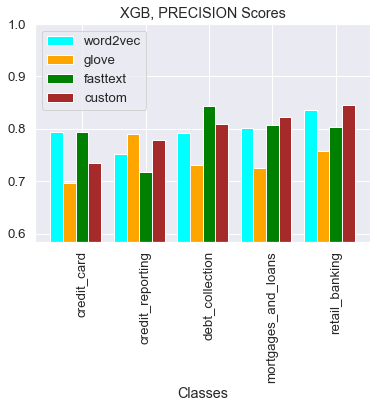

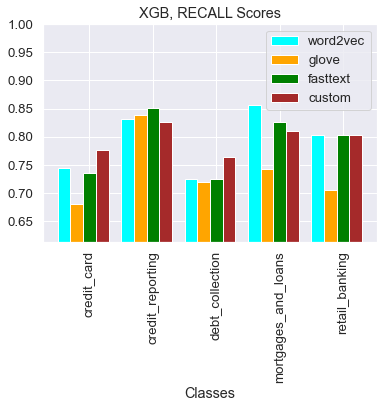

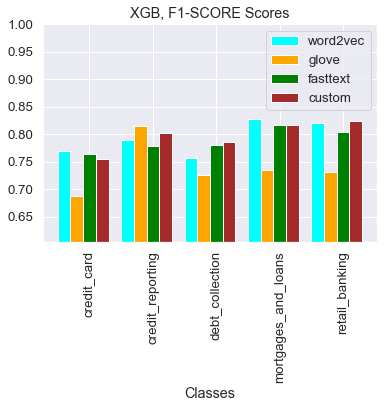

In [97]:
plot_results('xgb')

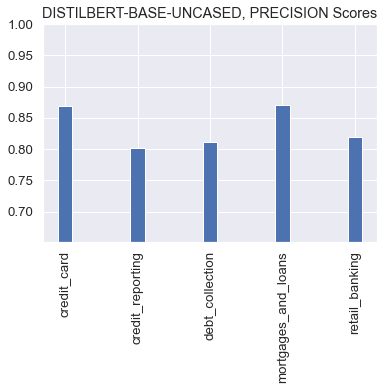

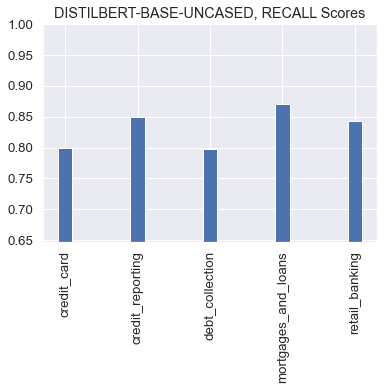

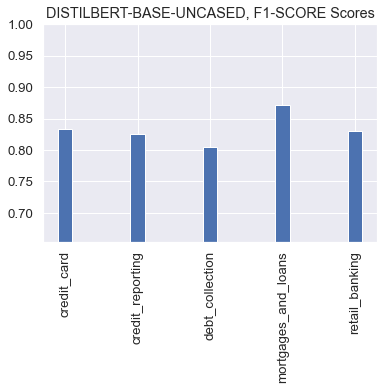

In [98]:
plot_results('distilbert-base-uncased', bert = True)

## Confusion Matrices

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_conf_mats(model, emb_name = None, bert = False):
    if bert: 
        path = f"results/{model}-conf_mat.csv"
        conf_mat = pd.read_csv(path, header = None, names = classes, dtype=np.float64)
        conf_mat.index = classes
        accuracy = test_results[test_results.model_name == model]['accuracy']

        sns.set(font_scale=1.2)
        sns.heatmap(conf_mat, annot=True, fmt='g', annot_kws={"size": 12})
        plt.title(f"{model.upper()}")
        plt.xlabel('PREDICTED')
        plt.ylabel('ACTUAL')
        plt.show()
    else: 
        n_classes = len(label_map)
        conf_mat_results = None
        if emb_name is None:
            embeddings_list = embeddings
        else: 
            embeddings_list = [emb_name]
        for emb in embeddings_list: 
            model_concat = f"{model}-{emb}"
            path = f"results/{model_concat}-conf_mat.csv"
            try: 
                conf_mat_model = pd.read_csv(path, header = None, names = classes, dtype=np.float64)
            except: 
                continue
            conf_mat_model.index = classes
            accuracy = test_results[test_results.model_name == model_concat]['accuracy']
            if conf_mat_results is None:
                conf_mat_results = conf_mat_model
            else: 
                conf_mat_results = conf_mat_results + conf_mat_model

        sns.set(font_scale=1.2)
        sns.heatmap(conf_mat_results, annot=True, fmt='g', annot_kws={"size": 12})
        plt.title(f"{model.upper()}")
        plt.xlabel('PREDICTED')
        plt.ylabel('ACTUAL')
        plt.show()

### XBG

Many misclassifications between (pred --> actual): 
- credit_card --> retail_banking/debt_collection
- credit_reporting --> debt_collection
- debt_collection --> credit_reporting
- mortgages_and_loans --> debt_collection

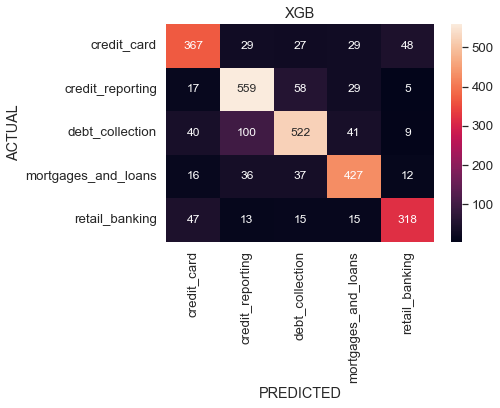

In [37]:
plot_conf_mats('xgb')

### distilBERT/BERT

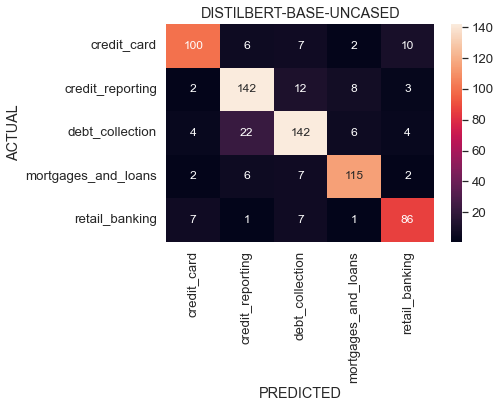

In [31]:
plot_conf_mats('distilbert-base-uncased', bert = True)

# 3. AI Interpretability

Instances to review: 
- For common misclassifications, what words appear most common between classes that could be causing errors? 
- what are the top words that the models use to separate classes?

In [32]:
import pickle
import model_funcs as mf
import pandas as pd
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report
model_name = 'xgb-glove'
with open(f'models/{model_name}.pkl', 'rb') as f: 
    model = pickle.load(f)

C:\Users\deguz\anaconda3\envs\tf\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [33]:
train_x, test_x, train_y, test_y, label_map  = mf.get_train_test()
train_vecs, test_vecs = mf.get_embedding_vecs('glove')
y_preds = model.predict(test_vecs)

Lowest precision/recall with credit_card + retail_banking class 

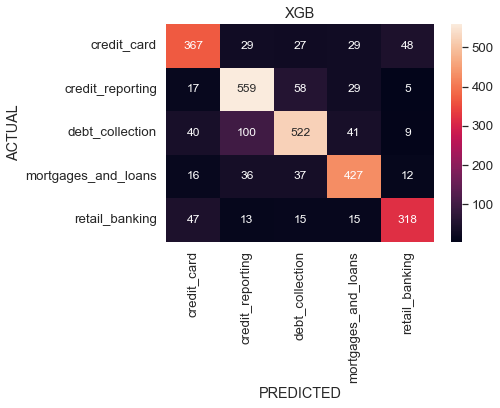

In [38]:
plot_conf_mats('xgb', emb_name=None)

In [52]:
def get_common_words(text_x, y_preds, y_true, top_n, pred_class, true_class): 
    #Get class codes
    pred_class = label_map[pred_class]
    true_class = label_map[true_class]

    samples = []
    for x, y_hat, y in zip(text_x, y_preds, y_true):
        if y_hat == pred_class and y == true_class: 
            samples.extend(x)
    
    counts = Counter(samples)
    return sorted(counts.items(), key=lambda x:x[1], reverse=True)[:top_n]

def compare_classes(pred_class, true_class): 
    incorrect_preds = np.array(get_common_words(test_x, y_preds, test_y, 15, pred_class=pred_class, true_class=true_class)) 
    correct_preds = np.array(get_common_words(test_x, y_preds, test_y, 15, pred_class=true_class, true_class=true_class)) 

    comparison_df = pd.DataFrame({'incorrect_pred_top_words': incorrect_preds[:,0],
                                    'incorrect_pred_counts': incorrect_preds[:,1],
                                    'correct_preds_top_words': correct_preds[:,0],
                                    'correct_preds_counts': correct_preds[:,1]
                                    })

    return comparison_df

In [53]:
compare_classes('credit_reporting', 'debt_collection')

,incorrect_pred_top_words,incorrect_pred_counts,correct_preds_top_words,correct_preds_counts
0,credit,73,debt,307
1,account,64,credit,210
2,information,59,account,173
3,report,49,collection,150
4,consumer,42,information,111
5,reporting,35,company,102
6,agency,27,report,93
7,please,21,reporting,78
8,debt,20,provide,76
9,collection,20,letter,72


In [55]:
compare_classes('credit_card', 'retail_banking')

,incorrect_pred_top_words,incorrect_pred_counts,correct_preds_top_words,correct_preds_counts
0,account,41,account,247
1,card,36,bank,138
2,credit,29,money,120
3,claim,26,fund,62
4,day,25,check,59
5,purchase,25,day,54
6,received,22,transaction,50
7,time,21,transfer,50
8,number,20,back,47
9,customer,20,would,46


### Word Distributions

In [90]:
def build_vocab_df(text_x, class_labels): 
    word_counts = pd.DataFrame(columns=['word'] + class_labels)
    for c in class_labels:
        word_counts[c].values[:] = 0
    vocab = list(set([x for l in test_x for x in l])); vocab = sorted(vocab)
    word_counts['word'] = vocab
    word_counts.fillna(0, inplace=True)
    return word_counts

def get_word_distributions(vocab_df, text_x, y_preds, y_true, classes = [], unique_only = False, index_start=0, index_end=20): 
    """
    'unique_only' flag: 
        True --> calculate distinct occurences of words in each class
        False --> calculate word frequencies in each class
    """
    word_counts = vocab_df.copy()
    class_keys = [label_map[k] for k in classes]
    for x, y_hat, y in zip(text_x, y_preds, y_true):
        if classes != []:
            if y not in class_keys: 
                continue
        x_counts = dict(Counter(x))
        
        class_name = class_labels[y]
        for word, count in x_counts.items(): 
            curr_count = word_counts.loc[word_counts['word'] == word, class_name]
            count = 1 if unique_only else count
            word_counts.loc[word_counts['word'] == word, class_name] = curr_count + count

    word_counts['total'] = word_counts[list(label_map.keys())].sum(axis=1)
    word_counts.sort_values(by='total', ascending=False, inplace=True)
    ax = word_counts.drop('total', axis=1)[index_start:index_end].plot.barh(x = 'word', stacked=True)
    ax.invert_yaxis()
    return word_counts


In [91]:
class_labels = list(label_map.keys())
vocab_df = build_vocab_df(test_x, class_labels)

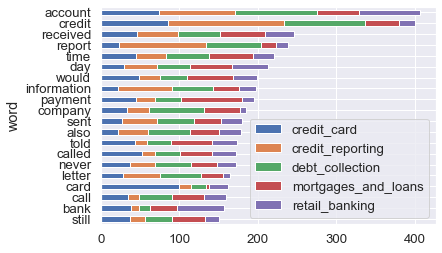

In [92]:
#Views the existence of common words in all classes
counts = get_word_distributions(vocab_df, 
                                test_x, 
                                y_preds, 
                                test_y, 
                                classes = [],
                                unique_only=True)

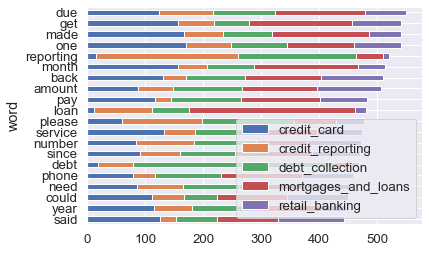

In [76]:
ax = counts.drop('total', axis=1)[20:40].plot.barh(x = 'word', stacked=True)
ax.invert_yaxis()

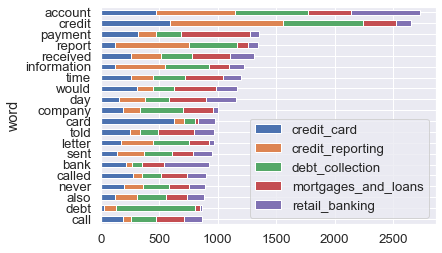

In [82]:
#Views the frequency of common words in all classes
count_freqs = get_word_distributions(vocab_df, 
                                test_x, 
                                y_preds, 
                                test_y, 
                                classes = [],
                                unique_only=False)

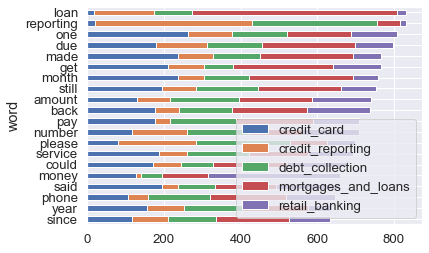

In [83]:
ax = count_freqs.drop('total', axis=1)[20:40].plot.barh(x = 'word', stacked=True)
ax.invert_yaxis()

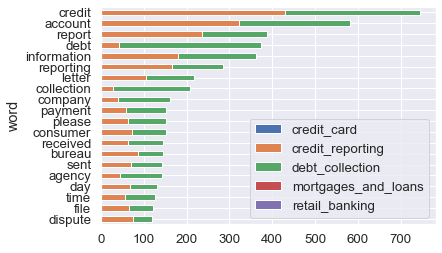

In [93]:
counts_cr_dc = get_word_distributions(vocab_df,
                                test_x, 
                                y_preds, 
                                test_y, 
                                classes=['credit_reporting', 'debt_collection'], 
                                unique_only=False)

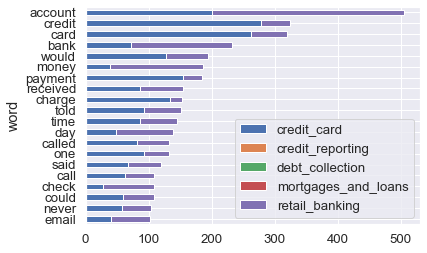

In [94]:
counts_cc_rb = get_word_distributions(vocab_df,
                                test_x, 
                                y_preds, 
                                test_y, 
                                classes=['credit_card', 'retail_banking'], 
                                unique_only=False)

### Primary Findings
- (predicted_class --> actual_class) misclassifications include: 
  * credit_card --> retail_banking/debt_collection
  * credit_reporting --> debt_collection
  * debt_collection --> credit_reporting
  * mortgages_and_loans --> debt_collection
- high overlap of words (many commonly used terms) across most classes, contributing to classification error
- additional data processing (stopwords + words with high occurence across classes) will allow: 
  * greater separation of classes for classification
  * smaller size of each training instance --> more samples to train models